# Digital Elevation Model (DEM) Tile Preprocessing

This Jupyter Notebook is dedicated to the initial, essential preprocessing steps required for the 1 arc-second resolution Digital Elevation Model (DEM) tiles covering the Ohio Region study area - 104 in total. Given the computational intensity associated with processing numerous high-resolution raster tiles, a strategy leveraging Virtual Raster Tiles (VRTs) will be employed instead of physically merging the tiles into a single large raster dataset. This approach allows for efficient handling of the data volume by treating the collection of tiles as a single virtual dataset without creating a massive intermediate file.

The preprocessing workflow in this notebook focuses on preparing the DEM data for subsequent watershed delineation, a process that is inherently agnostic to projection at this stage. Therefore, reprojection to a specific projected coordinate system like UTM will not be performed on the raw or preprocessed tiles. Instead, projection will be applied later to the delineated watershed boundaries and derived vector features.

The specific steps undertaken in this notebook are:

1. **Verification of Coordinate Reference System (CRS), Resolution and No Data Values:** Ensuring that all individual 1 arc-second DEM tiles are consistently referenced to the NAD83 datum (EPSG:4269), which is the native CRS for this dataset, and that all individual DEM tiles have the same resolution (expected 1 arc-second, approximately 0.000277778 degrees and approximately 30 meters), and that no tile have no data values. 
2. **Filling Pits, Depressions, and Resolving Flats:** Applying algorithms to identify and fill sinks and depressions within each individual DEM tile, and resolving flat areas. Sinks (or pits) are local topographic lows surrounded by higher elevation values, where water flow would terminate. Filling these depressions raises the elevation of sink cells to their lowest spill point, creating a hydrologically connected surface. Flats are areas with identical elevation values, causing ambiguous flow directions. Resolving flats assigns subtle elevation gradients to these areas, typically by imposing a small slope toward the nearest drain point, ensuring consistent flow paths. These steps are critical for accurately determining continuous flow paths across the terrain, a necessary prerequisite for deriving flow direction and accumulation grids used in automated watershed delineation.
3. **Creation of Virtual Raster Tiles (VRTs):** Constructing VRT files that virtually mosaic raw and preprocessed (sink-filled and flat-resolved) individual DEM tiles. These VRTs will serve as the input for subsequent terrain analysis steps, allowing seamless access to the data across tile boundaries without the need for physical mosaicking.

The output of this notebook will be a collection of sink-filled and flat-resolved DEM tiles, organized into a VRT, ready for flow direction and accumulation calculations leading to watershed delineation.

In [2]:
# Import libraries
import rasterio
import glob
from pysheds.grid import Grid
import numpy as np
from tqdm.notebook import tqdm
from subprocess import run
from pathlib import Path
import os
from matplotlib import pyplot as plt

OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


In [3]:
# Set paths
project_root_path = Path.cwd().parent.parent
dem_dir = project_root_path / 'data' / 'bronze' / 'geo' / 'raster' / 'dem1arcsec'
filled_dir = project_root_path /'data' / 'silver' / 'geo' / 'raster' / 'dem1arcsec_filled'
filled_dir.mkdir(parents=True, exist_ok=True)

## Step 1: Verify NAD83 CRS, Resolution and No Data Values.

Check the CRS of each DEM tile to ensure it’s NAD83 (expected: EPSG:4269). Report any tiles with a different CRS for manual inspection.

In [24]:
# Verify Coordinate Reference System (CRS)
# Get list of DEM files
dem_files = list(dem_dir.glob('*.tif'))
print(f"Found {len(dem_files)} DEM files.")

# Expected NAD83 CRS codes
nad83_crs = 'EPSG:4269'

# Check CRS for each tile
mismatched_tiles = []
for dem_file in tqdm(dem_files, desc="Checking CRS"):
    with rasterio.open(dem_file) as src:
        crs = str(src.crs).upper()
        if crs != nad83_crs:
            mismatched_tiles.append((dem_file, crs))

# Report results
if mismatched_tiles:
    print("\nTiles with non-NAD83 CRS:")
    for tile, crs in mismatched_tiles:
        print(f"{tile}: {crs}")
    print("Tiles should be reprojected to NAD83 (EPSG:4269).")
else:
    print("\nAll tiles are in NAD83 (EPSG:4269).")

Found 104 DEM files.


Checking CRS:   0%|          | 0/104 [00:00<?, ?it/s]


All tiles are in NAD83 (EPSG:4269).


In [25]:
# Verify Resolution
# Get list of DEM files
dem_files = list(dem_dir.glob('*.tif'))
print(f"Found {len(dem_files)} DEM files.")

# Expected resolution in degrees (1 arc second)
expected_res = [0.000277778,-0.000277778]

# Check CRS for each tile
mismatched_res_tiles = []
for dem_file in tqdm(dem_files, desc="Checking CRS"):
    with rasterio.open(dem_file) as src:
        x_res = round(src.meta['transform'][0], 9)
        y_res = round(src.meta['transform'][4], 9)
        if x_res not in  expected_res or y_res not in expected_res:
            mismatched_res_tiles.append((dem_file, (x_res, y_res)))

# Report results
if mismatched_res_tiles:
    print(f'Found {len(mismatched_res_tiles)} tiles with non-1-arc sec resolution.')
    print("\nTiles with non-1-arc sec resolution:")
    for tile, res in mismatched_res_tiles:
        print(f"{tile}: {res}")
    print("Tiles should be reprojected to 1-arc sec resolution.")
else:
    print("\nAll tiles are in 1-arc sec resolution.")

Found 104 DEM files.


Checking CRS:   0%|          | 0/104 [00:00<?, ?it/s]


All tiles are in 1-arc sec resolution.


In [26]:
# Verify Nodata Values
# Get list of DEM files
dem_files = list(dem_dir.glob('*.tif'))
print(f"Found {len(dem_files)} DEM files.")

# Check for nodata values in each tile
tiles_with_nodata = []
for dem_file in tqdm(dem_files, desc="Checking for nodata values"):
    with rasterio.open(dem_file) as src:
        # Check if the file has a defined nodata value
        if src.nodata is not None:
            # Read the first band and check for nodata values
            band = src.read(1)
            if (band == src.nodata).any():
                tiles_with_nodata.append(dem_file)
        else:
            # If no nodata value is defined, we'll consider it as having nodata for safety
            tiles_with_nodata.append(dem_file)

# Report results
if tiles_with_nodata:
    print(f'Found {len(tiles_with_nodata)} tiles containing nodata values.')
    print("\nTiles containing nodata values:")
    for tile in tiles_with_nodata:
        print(tile)
    print("These tiles should be processed to handle nodata values appropriately.")
else:
    print("\nNo tiles contain nodata values.")

Found 104 DEM files.


Checking for nodata values:   0%|          | 0/104 [00:00<?, ?it/s]


No tiles contain nodata values.


As expected, no tiles contain nodata values. 

## Step 2: Fill Sinks (Pits and Depressions)

Create a Virtual Raster Tile (VRT) to reference all 104 DEM tiles as a single dataset, avoiding memory-intensive merging for filling depression and sinks. Filling process will be performed, for each tile, considering its neighbouring cell, through the use of VRT. This ensures a hydrologically conditioned DEM for watershed delineation. Outputs are saved with LZW compression to reduce disk usage.

**LZW (Lempel-Ziv-Welch)** compression is a lossless data compression algorithm used to reduce the file size of raster data, such as GeoTIFF files (your DEM tiles), without losing any information. It is widely supported in geospatial tools like GDAL, rasterio, and GIS software (e.g., QGIS), making it ideal for compressing DEMs while preserving their exact elevation values.

- **Lossless:** Unlike lossy compression (e.g., JPEG), LZW ensures that the decompressed data is identical to the original, which is critical for scientific applications, where elevation accuracy affects flow paths and derived characteristics (e.g., slope, area).

- **Purpose**: LZW compression reduces the disk space required for the filled DEM tiles and minimizes I/O bottlenecks when reading/writing files.

### Inspect Example DEM

**NOTE**: There is a bug in pysheds package that throws an err with some grid methods. Solution is documented here: [NODATA issues with Python 13. #270](https://github.com/mdbartos/pysheds/issues/270)

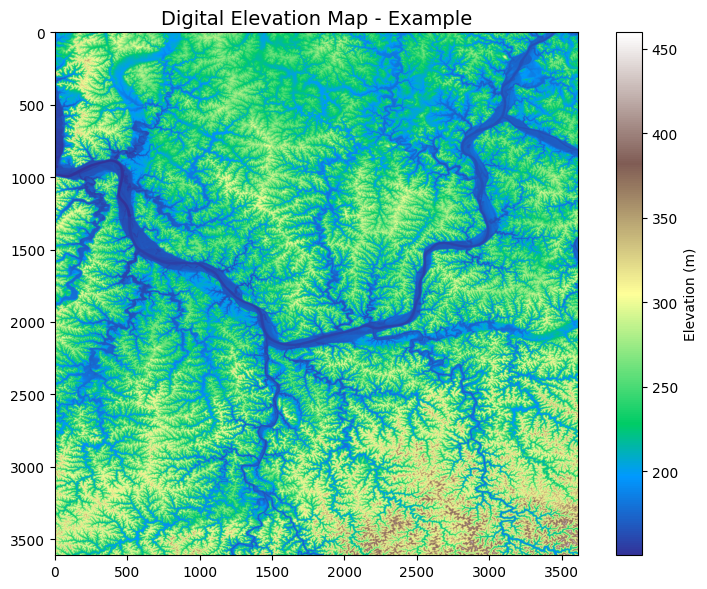

In [187]:
# Get DEM file
dem_file = glob.glob(f"{dem_dir}/*.tif")[2]

grid = Grid.from_raster(dem_file)
dem = grid.read_raster(dem_file)

# Plot the raw DEM
fig, ax = plt.subplots(figsize=(8,6))
fig.patch.set_alpha(0)

plt.imshow(grid.view(dem), cmap='terrain', zorder=1)
plt.colorbar(label='Elevation (m)')
plt.title('Digital Elevation Map - Example', size=14)
plt.tight_layout()


#### Pits

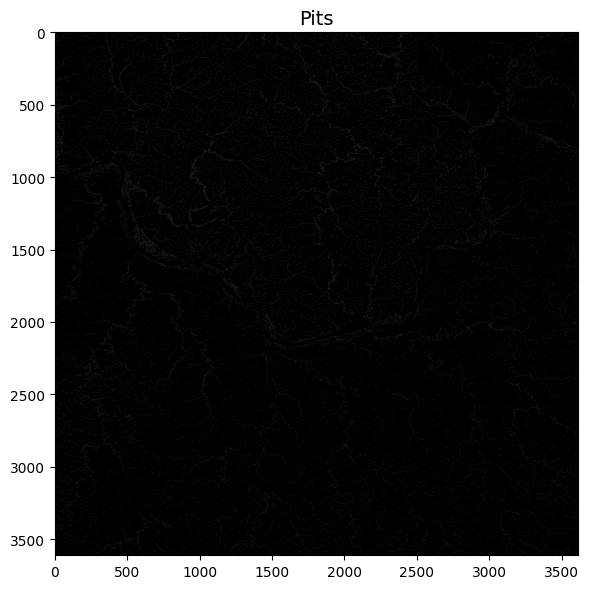

In [188]:
pits = grid.detect_pits(dem)

# Plot pits
fig, ax = plt.subplots(figsize=(8,6))
fig.patch.set_alpha(0)

plt.imshow(pits, cmap='Greys_r', zorder=1)
plt.title('Pits', size=14)
plt.tight_layout()

No pit in tile was deteced. It implemented, pits fill for safety and for batch processing.

In [189]:
# Fill pits
if pits.any():
    print(f"Found {pits.sum()} pits cell in tile. Filling pits...")
    # Fill pits
    pit_filled_dem = grid.fill_pits(dem)
else:
    print("No pits found in tile.")

Found 113749 pits cell in tile. Filling pits...


#### Depressions

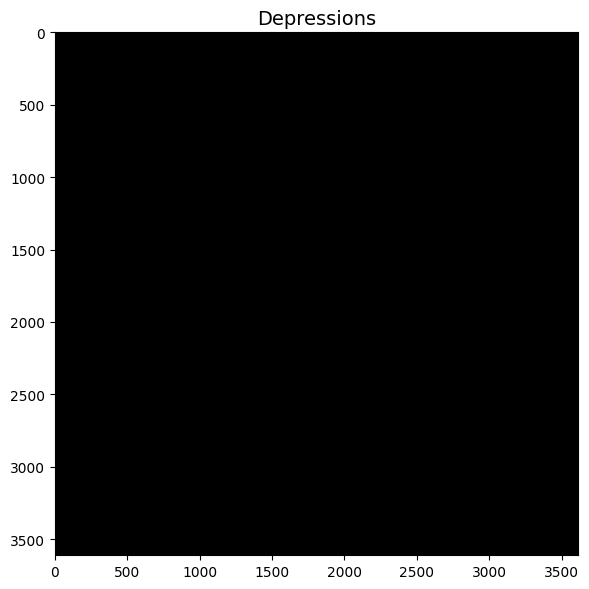

In [190]:
depressions = grid.detect_depressions(dem)
fig, ax = plt.subplots(figsize=(8,6))
fig.patch.set_alpha(0)

plt.imshow(depressions, cmap='Greys_r', zorder=1)
plt.title('Depressions', size=14)
plt.tight_layout()

In [191]:
if depressions.any():
    print(f"Found {depressions.sum()} depression cells in tile. Filling depressions...")
    flooded_dem = grid.fill_depressions(dem)
else:
    print("No depression cell found in tile.")

No depression cell found in tile.


#### Flats

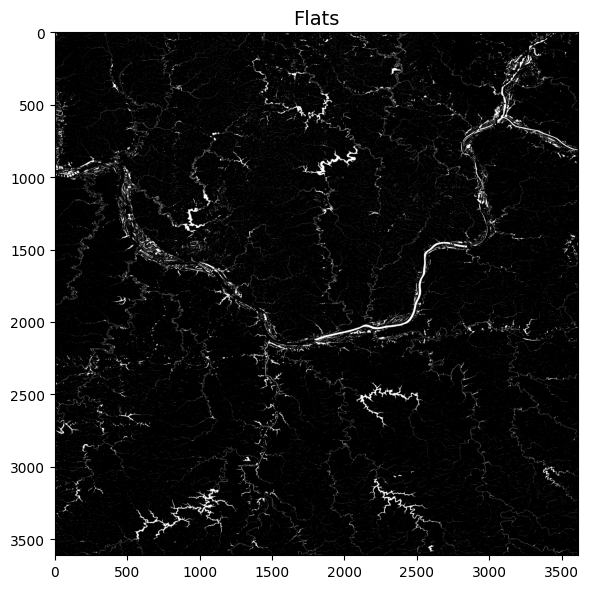

In [192]:
# Detect flats
flats = grid.detect_flats(flooded_dem)

# Plot flats
fig, ax = plt.subplots(figsize=(8,6))
fig.patch.set_alpha(0)

plt.imshow(flats, cmap='Greys_r', zorder=1)
plt.title('Flats', size=14)
plt.tight_layout()


In [193]:
if flats.any():
    print(f"Found {flats.sum()} flats cells in tile. Resolving flats...")
    inflated_dem = grid.resolve_flats(dem)
else:
    print("No flat areas found in tile.")

Found 484247 flats cells in tile. Resolving flats...


##### Final Product

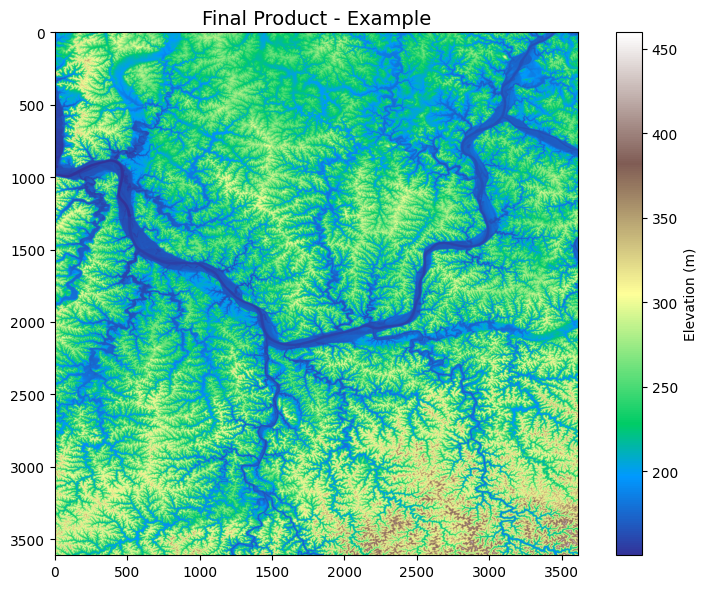

In [196]:
# Plot the raw DEM
fig, ax = plt.subplots(figsize=(8,6))
fig.patch.set_alpha(0)

plt.imshow(grid.view(inflated_dem), cmap='terrain', zorder=1)
plt.colorbar(label='Elevation (m)')
plt.title('Final Product - Example', size=14)
plt.tight_layout()

#### Batch Preprocessing
##### Create VRT

In [27]:
# Create VRT for original DEMs
dem_files = glob.glob(str(dem_dir / '*.tif'))
raw_vrt = project_root_path / 'data' / 'bronze' / 'geo' / 'raster' / 'dem1arcsec.vrt'
# Create VRT using gdalbuildvrt
print("Creating VRT for original DEMs...")
try:
    result = run(
        ['gdalbuildvrt', str(raw_vrt)] + dem_files,
        capture_output=True, text=True, check=True
    )
    print(f"VRT created: {raw_vrt}")
except FileNotFoundError:
    print("Error: gdalbuildvrt not found. Ensure GDAL is installed and in PATH.")
    print("Install with: brew install gdal")
except run.CalledProcessError as e:
    print(f"Error: VRT creation failed. gdalbuildvrt returned code {e.returncode}")
    print(f"STDERR: {e.stderr}")
    print(f"STDOUT: {e.stdout}")
except Exception as e:
    print(f"Unexpected error: {str(e)}")

# Verify VRT exists
if raw_vrt.exists():
    print(f"Confirmed: VRT file exists at {raw_vrt}")
else:
    print("Error: VRT file was not created.")

Creating VRT for original DEMs...
VRT created: /Users/alan/Data Science Projects/ML-ModClark-IUH-Model/data/bronze/geo/raster/dem1arcsec.vrt
Confirmed: VRT file exists at /Users/alan/Data Science Projects/ML-ModClark-IUH-Model/data/bronze/geo/raster/dem1arcsec.vrt


##### Preprocess Pipeline

Build function to clean files using buffered zones. This buffer it necessay to make to sure pits, and depression are filled and flat area are resolved, with sorrouding pixels, even for pixels located at the edge of raster files. 

In [5]:
import rasterio
from pysheds.grid import Grid
from pysheds.view import Raster, ViewFinder
import numpy as np
from pathlib import Path
import os

def process_dem_tile(dem_file, raw_vrt, buffer_pixels=10):
    """
    Process a DEM tile with buffering and hydrological corrections, cropping to original extent.

    Args:
    --------
        dem_file (str or pathlib.Path): Path to the input DEM tile file.
        raw_vrt (str or pathlib.Path): Path to the VRT file containing the DEM mosaic.
        buffer_pixels (int, optional): Number of pixels for buffer around tile. Defaults to 10.

    Returns:
    --------
        numpy.ndarray: Hydrologically corrected DEM array cropped to original tile extent.

    Raises:
    --------
        rasterio.errors.RasterioIOError: If there's an error reading the raster files.
        ValueError: If input parameters are invalid.
        Exception: For unexpected errors during processing.

    Steps Performed:
        1. Opens the VRT file to retrieve metadata (profile, transform, CRS).
        2. Opens the DEM tile to get its bounds and converts them to VRT pixel coordinates.
        3. Creates a buffered window around the tile extent, constrained by VRT dimensions.
        4. Reads the buffered DEM data from the VRT.
        5. Initializes a pysheds Grid and sets the buffered DEM with metadata.
        6. Sequentially processes hydrological features:
            - Fills pits (small sinks in the DEM).
            - Fills depressions (larger sinks).
            - Resolves flats (areas with no slope).
        7. Logs each processing step.
        8. Crops the processed DEM back to the original tile extent, removing the buffer.
    """
    print(f"Processing DEM tile: {os.path.basename(str(dem_file))}")

    try:
        # Convert Path objects to strings
        dem_file = str(dem_file) if isinstance(dem_file, Path) else dem_file
        raw_vrt = str(raw_vrt) if isinstance(raw_vrt, Path) else raw_vrt

        # Validate input
        if not isinstance(dem_file, str):
            raise ValueError("dem_file must be a string or Path object")
        if not isinstance(raw_vrt, str):
            raise ValueError("raw_vrt must be a string or Path object")

        # Open VRT and get metadata
        with rasterio.open(raw_vrt) as vrt_src:
            vrt_profile = vrt_src.profile
            vrt_transform = vrt_src.transform
            vrt_width, vrt_height = vrt_src.width, vrt_src.height
            nodata = vrt_profile.get('nodata', None)

        # Process tile extent with buffer
        with rasterio.open(dem_file) as tile_src:
            tile_bounds = tile_src.bounds

            # Get DEM tile metadata
            dem_affine = tile_src.transform
            dem_shape = (tile_src.height, tile_src.width)
            dem_crs = tile_src.crs
            dem_nodata = tile_src.nodata
            
            # Convert DEM bounds to VRT pixel coordinates
            col_start, row_start = map(int, ~vrt_transform * (tile_bounds.left, tile_bounds.top))
            col_stop, row_stop = map(int, ~vrt_transform * (tile_bounds.right, tile_bounds.bottom))

            # Create buffered window
            window = rasterio.windows.Window(
                col_off=max(0, col_start - buffer_pixels),
                row_off=max(0, row_start - buffer_pixels),
                width=min(vrt_width - col_start + buffer_pixels, col_stop - col_start + 2 * buffer_pixels),
                height=min(vrt_height - row_start + buffer_pixels, row_stop - row_start + 2 * buffer_pixels)
            )

            # Read buffered data from VRT and get metadata to build pysheds sView raster
            with rasterio.open(raw_vrt) as vrt_src:
                array = vrt_src.read(1, window=window)
                transform = vrt_src.window_transform(window)
                shape = array.shape
                crs = vrt_src.crs
                nodata = np.float32(vrt_src.nodata)

        # Build pysheds raster and set buffered raster with metadata
        view_finder = ViewFinder(
            affine = transform,
            shape = shape,
            crs = crs,
            nodata = nodata
        )
        raster = Raster(array, viewfinder=view_finder)
        
        # Initialize pysheds Grid
        grid = Grid.from_raster(data = raster)

        # Process hydrological features
        processing_steps = [
            ('pits', grid.fill_pits),
            ('depressions', grid.fill_depressions),
            ('flats', grid.resolve_flats)
        ]
        for feature_name, process_func in processing_steps:
            print(f"Processing {feature_name}...")
            raster = process_func(raster)
        print("\n")

        # Crop data back to original tile extent (remove buffer)
        buffer_start = buffer_pixels if window.col_off < col_start else 0
        buffer_top = buffer_pixels if window.row_off < row_start else 0
        cropped_array = raster[
            buffer_top:buffer_top + (row_stop - row_start),
            buffer_start:buffer_start + (col_stop - col_start)
        ]

        # Crop mask back to original tile extent (remove buffer)
        cropped_mask = raster.mask[
            buffer_top:buffer_top + (row_stop - row_start),
            buffer_start:buffer_start + (col_stop - col_start)
        ]
        cropped_array = np.asarray(cropped_array) # Drop metadata that my colide with hanging around mask metadata

        # Build new ViewFinder for the cropped raster
        cropped_viewfinder = ViewFinder(
            affine=dem_affine,
            shape=dem_shape,
            crs=dem_crs,
            nodata=dem_nodata,
            mask=cropped_mask
        )
        # Build new Raster object

        cropped_raster = Raster(
            cropped_array,
            viewfinder=cropped_viewfinder
        )

        return cropped_raster

    except rasterio.errors.RasterioIOError as e:
        print(f"Error reading raster files: {e}")
        raise
    except ValueError as e:
        print(f"Input validation error: {e}")
        raise
    except Exception as e:
        print(f"Unexpected error during processing: {e}")
        raise

In [ ]:
# Test the function with a DEM example tile
dem_file = glob.glob(f"{dem_dir}/*.tif")[2]
raw_vrt = project_root_path / 'data' / 'bronze' / 'geo' / 'raster' / 'dem1arcsec.vrt'

example_tile_processed = process_dem_tile(dem_file=dem_file, raw_vrt=raw_vrt, buffer_pixels=10)

Processing DEM tile: USGS_1_n39w083_20240923.tif
Processing pits...
Processing depressions...
Processing flats...


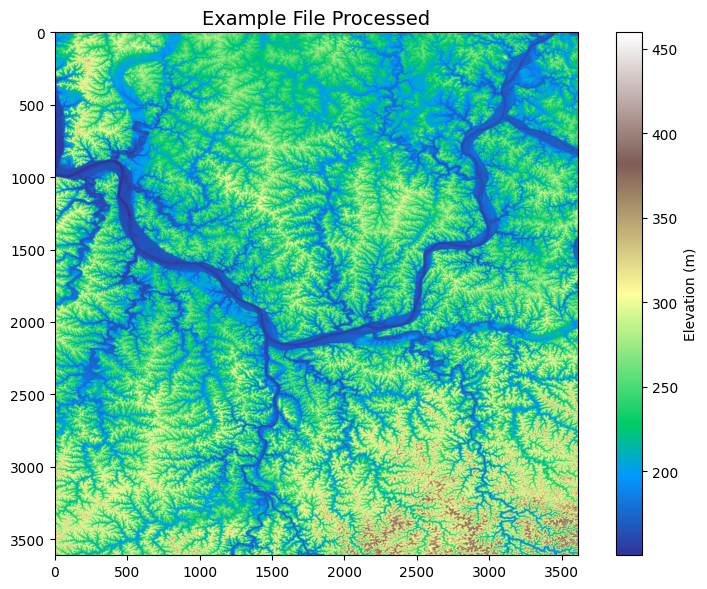

In [306]:
# Plot the Example tile processed
fig, ax = plt.subplots(figsize=(8,6))
fig.patch.set_alpha(0)

plt.imshow(grid.view(example_tile_processed), cmap='terrain', zorder=1)
plt.colorbar(label='Elevation (m)')
plt.title('Example File Processed', size=14)
plt.tight_layout()

In [6]:
import rasterio

def save_raster_to_file(output_file, cropped_raster):
    """
    Save a pysheds Raster object to a GeoTIFF with LZW compression.

    Args:
    --------
        output_file (str or pathlib.Path): Path to save the output file.
        cropped_raster (pysheds.view.Raster): The processed Raster object to save.

    Raises:
    --------
        rasterio.errors.RasterioIOError: If there's an error writing the raster.
        Exception: For unexpected errors during saving.
    """
    try:
        # Ensure data is a masked array or regular array
        data = np.asarray(cropped_raster)

        # Check if there is a mask
        mask = cropped_raster.mask
        if mask is not None:
            # Apply mask: set nodata where mask is True
            data = np.where(mask, cropped_raster.viewfinder.nodata, data)

        # Get metadata from viewfinder
        vf = cropped_raster.viewfinder
        height, width = vf.shape
        transform = vf.affine
        crs = vf.crs
        nodata = vf.nodata

        # Write to GeoTIFF
        with rasterio.open(
            output_file,
            'w',
            driver='GTiff',
            height=height,
            width=width,
            count=1,
            dtype='float32',
            crs=crs,
            transform=transform,
            nodata=nodata,
            compress='LZW'
        ) as dst:
            dst.write(data.astype('float32'), 1)

        print(f"Raster saved successfully to {output_file}\n")

    except rasterio.errors.RasterioIOError as e:
        print(f"Error writing raster file: {e}")
        raise
    except Exception as e:
        print(f"Unexpected error during saving raster: {e}")
        raise


In [312]:
output_example_processed_tile = os.path.join(filled_dir, os.path.basename(dem_file))
save_raster_to_file(output_example_processed_tile, example_tile_processed)

# Verify the output file
if os.path.exists(output_example_processed_tile):
    print(f"Confirmed: Output file exists at {output_example_processed_tile}")
else:
    print("Error: Output file was not created.")


Raster saved successfully to /Users/alan/Data Science Projects/ML-ModClark-IUH-Model/data/silver/geo/raster/dem1arcsec_filled/USGS_1_n39w083_20240923.tif

Confirmed: Output file exists at /Users/alan/Data Science Projects/ML-ModClark-IUH-Model/data/silver/geo/raster/dem1arcsec_filled/USGS_1_n39w083_20240923.tif


In [ ]:
# Batch process and save tiles
# Test the function with a DEM example tile
dem_files = glob.glob(f"{dem_dir}/*.tif")
raw_vrt = project_root_path / 'data' / 'bronze' / 'geo' / 'raster' / 'dem1arcsec.vrt'

count =0
length =  len(dem_files)
for dem_file in dem_files:
    count +=1
    print(f"{count} / {length}")
    try:
        cropped_raster = process_dem_tile(dem_file, raw_vrt, buffer_pixels=10)
        output_file =  os.path.join(filled_dir, os.path.basename(dem_file))
        save_raster_to_file(output_file, cropped_raster)
        
    except Exception as e:
        print(f"❌ Error processing {dem_file}: {e}")

## Step 3: Create VRT for preprocessed DEMs

Create a VRT for the preprocessed DEMs, which will be used for watershed delineation and deriving characteristics in the next notebook. However, before proceeding, the preprocessed tiles will be checked for overlaps and gaps.

### Check Overlaps and Gaps

In [ ]:
import re
import rasterio
from rasterio.merge import merge
import numpy as np

def parse_coords(filename):
    # Example filename: USGS_1_n36w078_20250507
    match = re.search(r'n(\d+)w(\d+)', filename)
    if match:
        lat = int(match.group(1))
        lon = -int(match.group(2))
        return lat, lon
    else:
        raise ValueError(f"Filename {filename} doesn't match expected pattern")

def find_neighbor(tile_coords, all_coords, direction='right'):
    lat, lon = tile_coords
    if direction == 'right':
        # find tile with same lat and lon + 1 (assuming 1 degree tiles)
        return next(((lt, ln) for lt, ln in all_coords if lt == lat and ln == lon + 1), None)
    elif direction == 'bottom':
        # find tile with lat - 1 and same lon
        return next(((lt, ln) for lt, ln in all_coords if lt == lat - 1 and ln == lon), None)

def check_pair(tile1_path, tile2_path):
    with rasterio.open(tile1_path) as src1, rasterio.open(tile2_path) as src2:
        # Merge two masks using rasterio.merge
        mosaic, _ = merge([src1, src2], method='sum')

        coverage = mosaic[0]
        overlaps = (coverage > 1).sum()
        gaps = (coverage == 0).sum()

        return overlaps, gaps

def check_all_pairs(tile_paths):
    coords_map = {}
    for path in tile_paths:
        lat, lon = parse_coords(path)
        coords_map[(lat, lon)] = path

    all_coords = sorted(coords_map.keys(), key=lambda x: (-x[0], x[1]))  # sort north->south, west->east

    for coord in all_coords:
        right_neighbor = find_neighbor(coord, all_coords, 'right')
        if right_neighbor:
            overlaps, gaps = check_pair(coords_map[coord], coords_map[right_neighbor])
            print(f"Right pair {coord} & {right_neighbor}: overlaps={overlaps}, gaps={gaps}")

        bottom_neighbor = find_neighbor(coord, all_coords, 'bottom')
        if bottom_neighbor:
            overlaps, gaps = check_pair(coords_map[coord], coords_map[bottom_neighbor])
            print(f"Bottom pair {coord} & {bottom_neighbor}: overlaps={overlaps}, gaps={gaps}")


In [12]:
tiles_path = [str(path) for path in list(filled_dir.glob('*.tif'))]
check_all_pairs(tiles_path)

Right pair (43, -90) & (43, -89): overlaps=0, gaps=0
Bottom pair (43, -90) & (42, -90): overlaps=0, gaps=0
Right pair (43, -89) & (43, -88): overlaps=0, gaps=0
Bottom pair (43, -89) & (42, -89): overlaps=0, gaps=0
Right pair (43, -88) & (43, -87): overlaps=0, gaps=0
Bottom pair (43, -88) & (42, -88): overlaps=0, gaps=0
Right pair (43, -87) & (43, -86): overlaps=0, gaps=0
Bottom pair (43, -87) & (42, -87): overlaps=0, gaps=0
Right pair (43, -86) & (43, -85): overlaps=0, gaps=0
Bottom pair (43, -86) & (42, -86): overlaps=0, gaps=0
Right pair (43, -85) & (43, -84): overlaps=0, gaps=0
Bottom pair (43, -85) & (42, -85): overlaps=0, gaps=0
Right pair (43, -84) & (43, -83): overlaps=0, gaps=0
Bottom pair (43, -84) & (42, -84): overlaps=0, gaps=0
Right pair (43, -83) & (43, -82): overlaps=0, gaps=0
Bottom pair (43, -83) & (42, -83): overlaps=0, gaps=0
Right pair (43, -82) & (43, -81): overlaps=0, gaps=0
Bottom pair (43, -82) & (42, -82): overlaps=0, gaps=0
Right pair (43, -81) & (43, -80): ove

### Create VRT for Processed Tiles
From above, there is continuity and no overlapping in tiles. VRT can  safely be created. 

In [14]:
# Create VRT for processed tiles
dem_files = [str(path) for path in list(filled_dir.glob('*.tif'))]
processed_vrt = project_root_path / 'data' / 'silver' / 'geo' / 'raster' / 'dem1arcsec.vrt'

# Create VRT using gdalbuildvrt
print("Creating VRT for processed tiles...")
try:
    result = run(
        ['gdalbuildvrt', str(processed_vrt)] + dem_files,
        capture_output=True, text=True, check=True
    )
    print(f"VRT created: {processed_vrt}")
except FileNotFoundError:
    print("Error: gdalbuildvrt not found. Ensure GDAL is installed and in PATH.")
    print("Install with: brew install gdal")
except run.CalledProcessError as e:
    print(f"Error: VRT creation failed. gdalbuildvrt returned code {e.returncode}")
    print(f"STDERR: {e.stderr}")
    print(f"STDOUT: {e.stdout}")
except Exception as e:
    print(f"Unexpected error: {str(e)}")

# Verify VRT exists
if processed_vrt.exists():
    print(f"Confirmed: VRT file exists at {processed_vrt}")
else:
    print("Error: VRT file was not created.")

Creating VRT for processed tiles...
VRT created: /Users/alan/Data Science Projects/ML-ModClark-IUH-Model/data/silver/geo/raster/dem1arcsec.vrt
Confirmed: VRT file exists at /Users/alan/Data Science Projects/ML-ModClark-IUH-Model/data/silver/geo/raster/dem1arcsec.vrt
